In [13]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from skimage import measure

import numpy as np
from skimage import measure
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os
import numpy as np
import xarray as xr
import sys
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt




# Ensure pySAMetrics is available in your Python environment
import pySAMetrics
from pySAMetrics.Simulation_2 import Simulation
from pySAMetrics.utils import generate_simulation_paths

from pySAMetrics.Simulation_2 import Simulation

data_dict = {}

for i in range(1, 49):
    data_dict[f'split_{i}'] = {
        'velocity': '8',
        'temperature': '300',
        'bowen_ratio': '1',
        'microphysic': '1',
        'split': str(i)
    }


In [14]:


def load_simulation(simu_parameters, i=1000, path_raw_data='/Volumes/LaCie/000_POSTDOC_2025/long_high_res'):
    """
    Load and run the simulation for the given parameters.

    Parameters:
    - simu_parameters (dict): Dictionary containing simulation parameters.

    Returns:
    - Simulation object or None if failed to load.
    """
    try:
        if i!=1000:
            paths = {
            'path_3d': os.path.join(path_raw_data, f'3D/split_{i+1}.nc'),
            'path_2d': os.path.join(path_raw_data, f'2D/split_{i+1}.nc'),
            'path_1d': os.path.join(path_raw_data, f'1D/split_{i+1}.nc'),
            }

        else:
            paths = generate_simulation_paths(**simu_parameters, folder_path=path_raw_data)
            print(paths)

        simu = Simulation(data_folder_paths=[paths['path_1d'], paths['path_2d'], paths['path_3d']],
                          **simu_parameters)
        return simu
    
    except FileNotFoundError as e:
        print(f"Error: {e}. Please check the simulation paths.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}.")
    
    return None

In [15]:
data_dict = {}

for i in range(1, 49):
    data_dict[f'split_{i}'] = {
        'velocity': '8',
        'temperature': '300',
        'bowen_ratio': '1',
        'microphysic': '1',
        'split': str(i)
    }
#list_files = [f'split_{i}' for i in range(4,40)]
list_files = [f'split_{i}' for i in range(4,5)]

mp.set_start_method("spawn", force=True)

for i_file,file in tqdm(enumerate(list_files, start=4)):
    print('Run', file)
    parameters = data_dict[file]

    simu = load_simulation(parameters, i=i_file)
    print(simu.name)

   

0it [00:00, ?it/s]

1it [00:00, 15.72it/s]

Run split_4
RCE_T300_U8_B1_M1_split_4


In [16]:
simu.load(backup_folder_path=f'/Volumes/LaCie/000_POSTDOC_2025/long_high_res/saved_simu')


In [17]:
np.savetxt('z_array.txt', simu.dataset_3d.z.values)


In [18]:
from pySAMetrics.basic_variables import set_basic_variables_from_dataset_add
set_basic_variables_from_dataset_add(simulation=simu)

In [19]:
simu.dataset_computed_3d

<xarray.Dataset> Size: 25GB
Dimensions:                (time: 541, z: 64, y: 128, x: 128)
Dimensions without coordinates: time, z, y, x
Data variables:
    FMSE                   (time, z, y, x) float32 2GB 3.426e+05 ... 4.863e+05
    VIRTUAL_TEMPERATURE    (time, z, y, x) float32 2GB ...
    POTENTIAL_TEMPERATURE  (time, z, y, x) float32 2GB ...
    BUOYANCY               (time, z, y, x) float32 2GB ...
    VORTICITY              (time, z, y, x) float32 2GB ...
    RHO_W                  (time, z, y, x) float32 2GB ...
    QN_ice                 (time, z, y, x) float32 2GB 0.0 0.0 0.0 ... 0.0 0.0
    QN_liq                 (time, z, y, x) float32 2GB 0.0 0.0 0.0 ... 0.0 0.0
    QP_ice                 (time, z, y, x) float32 2GB 0.0 0.0 0.0 ... 0.0 0.0
    QP_liq                 (time, z, y, x) float32 2GB 0.0 0.0 0.0 ... 0.0 0.0
    FFMSE                  (time, z, y, x) float32 2GB 3.426e+05 ... 4.863e+05

In [20]:
mean_qn = np.mean(simu.dataset_computed_3d.QN_liq[100], axis=(-1, -2))

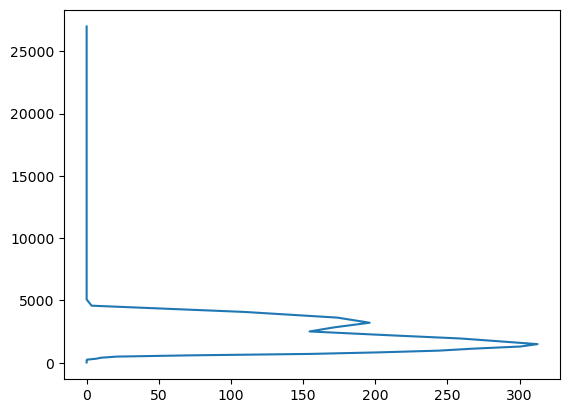

In [21]:
plt.plot(334e5*mean_qn/1000, z)

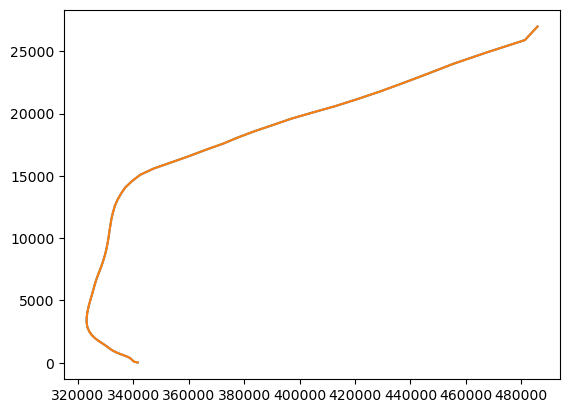

In [22]:
ffmse = np.mean(simu.dataset_computed_3d.FFMSE[100], axis=(-1, -2))
fmse = np.mean(simu.dataset_computed_3d.FMSE[100], axis=(-1, -2))

z = simu.dataset_3d.z.values
plt.plot(ffmse,z)
plt.plot(ffmse, z)


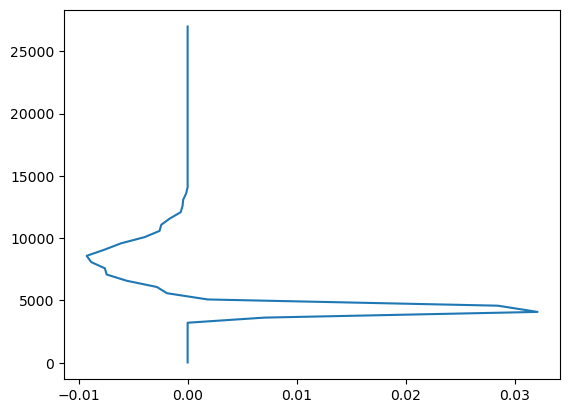

In [23]:
mean_qpice = simu.dataset_1d.RHO[100].values* np.mean(simu.dataset_computed_3d.QP_ice[100], axis=(-1, -2))/1000
dz_mean_qpice = np.gradient(mean_qpice, z)

result = 0.4*334e5*dz_mean_qpice
plt.plot(result,z)

In [24]:
rho_w = simu.dataset_computed_3d.RHO_W.values 
RHO_W_plus = np.full_like(rho_w, np.nan)
RHO_W_minus = np.full_like(rho_w, np.nan)

epsilom=0.5
RHO_W_plus[rho_w > epsilom] = rho_w[rho_w > epsilom]
RHO_W_minus[rho_w <epsilom] = rho_w[rho_w < epsilom]


In [25]:
#rho_w = simu.dataset_computed_3d.RHO_W.values 
fmse = simu.dataset_computed_3d.FMSE.values 
fmse_plus = np.full_like(fmse, np.nan)
fmse_minus = np.full_like(fmse, np.nan)

fmse_plus[rho_w > epsilom] = fmse[rho_w > epsilom]
fmse_minus[rho_w < epsilom] = fmse[rho_w <epsilom]


In [26]:
np.sum((rho_w > epsilom)*1)/(128*128*64*500)

np.float64(0.013945186614990234)

In [27]:
fmse_plus.shape

(541, 64, 128, 128)

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/157296605.py:4: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(fmse_plus[10], axis=(-1,-2)), z/1000, label='H+')


(0.0, 15.0)

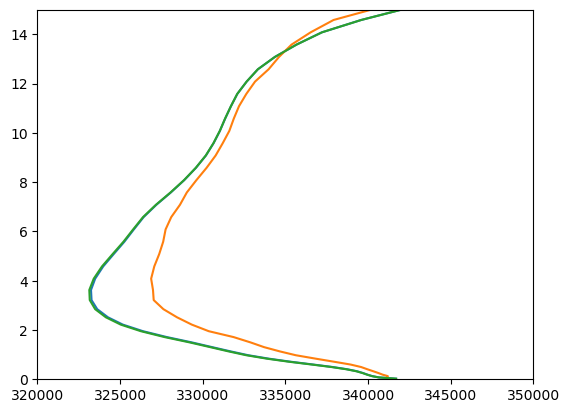

In [28]:
import matplotlib.pyplot as plt
z=simu.dataset_3d.z.values
plt.plot(np.nanmean(fmse[10], axis=(-1,-2)), z/1000, label='H')
plt.plot(np.nanmean(fmse_plus[10], axis=(-1,-2)), z/1000, label='H+')
plt.plot(np.nanmean(fmse_minus[10], axis=(-1,-2)), z/1000, label='H-')

plt.xlim(320000, 350000)
plt.ylim(0,15)

In [29]:
fmse_plus.shape

(541, 64, 128, 128)

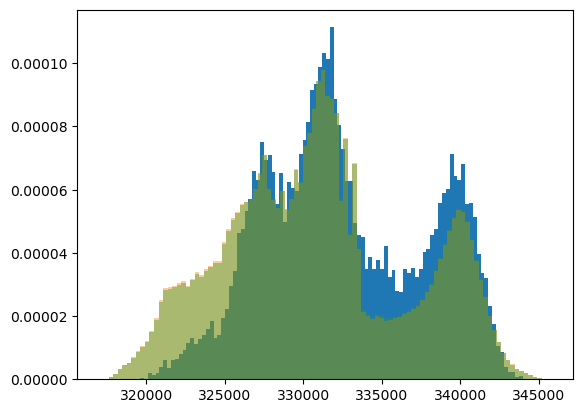

In [30]:
nz=40
plt.hist(fmse_plus[30,:nz].flatten(), density=True, bins=100)
plt.hist(fmse_minus[30,:nz].flatten(), alpha=0.4, density=True, bins=100)
plt.hist(fmse[30,:nz].flatten(), alpha=0.4, density=True, bins=100)
plt.show()









(array([2.900000e+01, 3.170000e+02, 1.836600e+04, 1.027292e+06,
        1.794000e+03, 4.590000e+02, 1.980000e+02, 8.100000e+01,
        2.800000e+01, 1.200000e+01]),
 array([-7.14405584, -4.91779327, -2.6915307 , -0.46526814,  1.76099443,
         3.98725748,  6.21351957,  8.43978119, 10.66604424, 12.89230728,
        15.11857033]),
 <BarContainer object of 10 artists>)

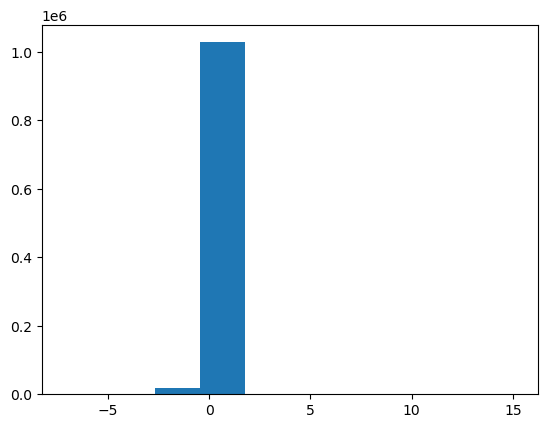

In [31]:
plt.hist(rho_w[10].flatten())

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        5.00000e+00, 3.00000e+00, 3.00000e+00, 7.00000e+00, 9.00000e+00,
        7.00000e+00, 7.00000e+00, 1.20000e+01, 1.40000e+01, 2.80000e+01,
        2.80000e+01, 3.70000e+01, 5.10000e+01, 6.00000e+01, 7.30000e+01,
        1.18000e+02, 1.49000e+02, 2.26000e+02, 3.06000e+02, 4.38000e+02,
        6.27000e+02, 9.56000e+02, 1.58700e+03, 3.21500e+03, 1.07440e+04,
        5.65970e+04, 2.70468e+05, 6.14304e+05, 6.48250e+04, 1.33620e+04,
        3.82800e+03, 1.70800e+03, 1.01300e+03, 6.73000e+02, 5.14000e+02,
        3.61000e+02, 3.16000e+02, 2.41000e+02, 2.04000e+02, 1.66000e+02,
        1.44000e+02, 1.10000e+02, 7.90000e+01, 8.80000e+01, 8.50000e+01,
        6.70000e+01, 5.70000e+01, 6.00000e+01, 4.30000e+01, 5.70000e+01,
        3.90000e+01, 3.80000e+01, 4.00000e+01, 3.60000e+01, 2.20000e+01,
        2.60000e+01, 2.50000e+01, 2.00000e+01, 2.40000e+01, 1.90000e+01,
        1.10000e+01, 2.10000e+01, 1.60000e+01, 1.90

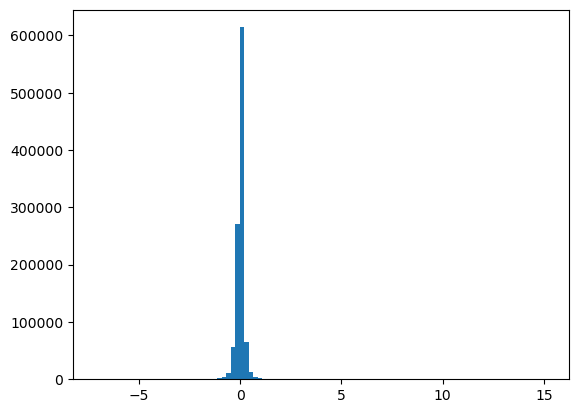

In [32]:

plt.hist(rho_w[10].flatten(), bins=100)

In [33]:
RHO_W_plus_to_num = np.nan_to_num(RHO_W_plus)
RHO_W_minus_to_num = np.nan_to_num(RHO_W_minus)

In [34]:
from pySAMetrics.diagnostic_fmse_v2 import get_isentropic_var

rhow_plus_isent = get_isentropic_var(simu, mode='sum', mode_rhow=False, other_var=RHO_W_plus_to_num)
rhow_minus_isent = get_isentropic_var(simu, mode='sum', mode_rhow=False, other_var=RHO_W_minus_to_num)

  0%|          | 0/34624 [00:00<?, ?it/s]

100%|██████████| 541/541 [00:03<00:00, 175.62it/s]


In [35]:
import matplotlib.pyplot as plt

In [36]:
z = simu.dataset_3d.z.values
dz = np.gradient(simu.dataset_3d.z.values)

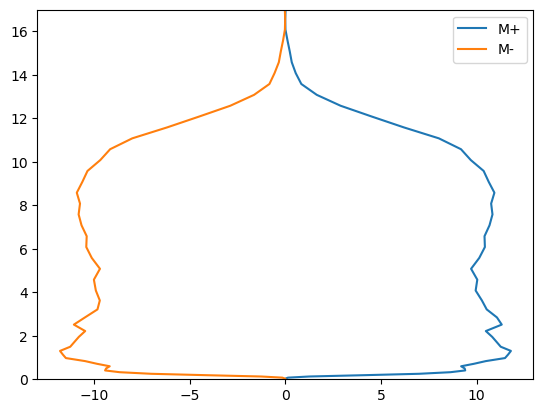

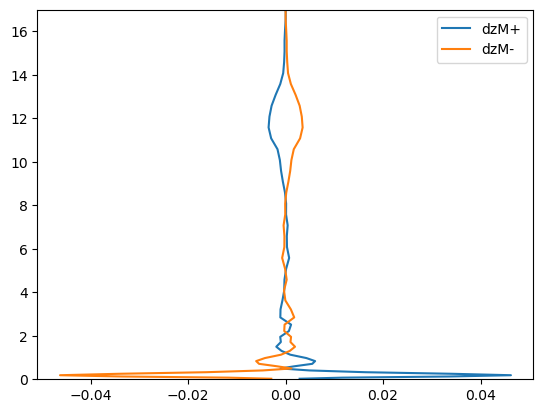

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/3485680201.py:18: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(fmse_plus[nt], axis=(-2, -1)), z/1000, label='H+')


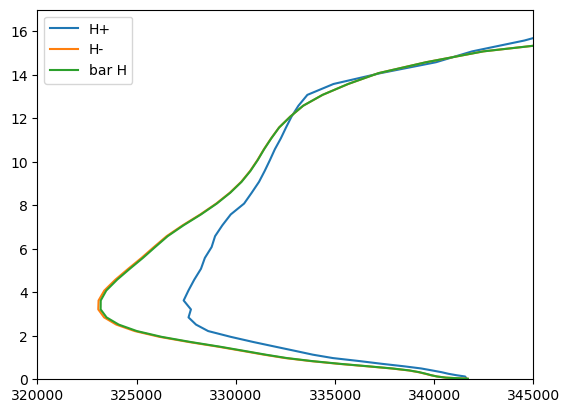

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/3485680201.py:27: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(fmse_plus[nt], axis=(-1, -2))-np.nanmean(fmse[nt], axis=(-1, -2)), z/1000, label='H+-bar(Hm)')


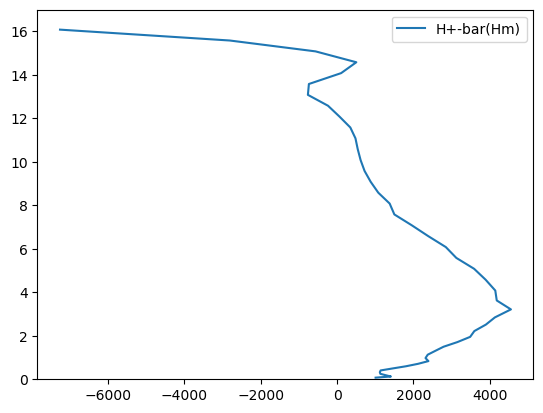

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/3485680201.py:32: RuntimeWarning: Mean of empty slice
  plt.plot(np.gradient(np.nanmean(fmse_plus[nt], axis=(-1,-2)), z), z/1000, label='dzH+')


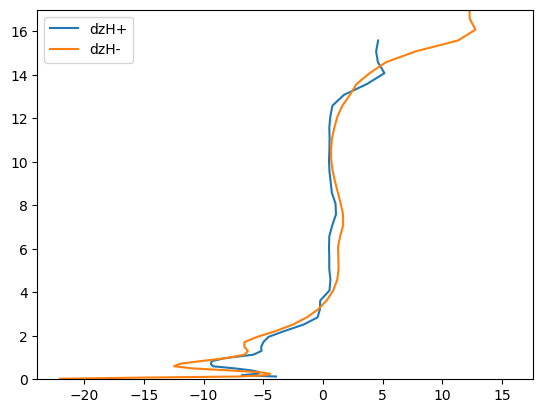

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/3485680201.py:40: RuntimeWarning: Mean of empty slice
  plt.plot(-np.gradient(np.nanmean(fmse_plus[nt], axis=(-1,-2)), z), z/1000, label='-dzH+')


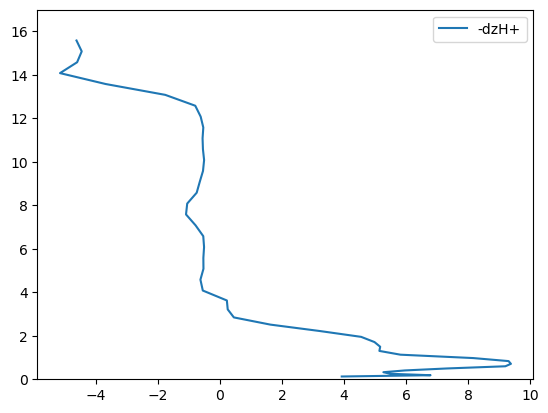

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/3485680201.py:47: RuntimeWarning: Mean of empty slice
  mean_fmse_plus = np.nanmean(fmse_plus[nt], axis=(-1, -2))
/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/3485680201.py:68: RuntimeWarning: Mean of empty slice
  D = E - 1/np.nanmean(RHO_W_plus[nt], axis=(-1, -2)) * np.gradient(np.nanmean(RHO_W_plus[nt], axis=(-1, -2)), z)


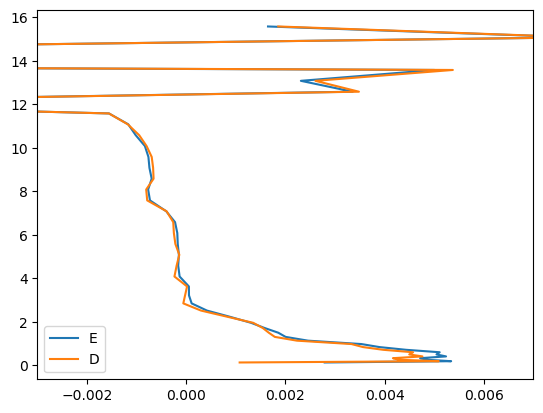

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/3485680201.py:76: RuntimeWarning: Mean of empty slice
  D = E - 1/np.nanmean(RHO_W_plus[nt], axis=(-1, -2)) * np.gradient(np.nanmean(RHO_W_plus[nt], axis=(-1, -2)), z)


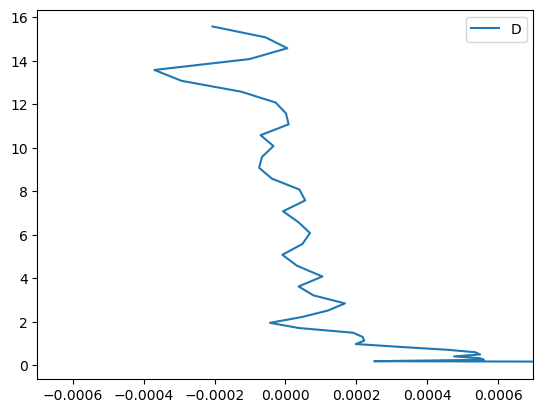

In [37]:
nt=60


plt.plot(np.nanmean(rhow_plus_isent[nt], axis=1), z/1000, label='M+')
plt.plot(np.nanmean(rhow_minus_isent[nt], axis=1), z/1000, label='M-')
plt.ylim(0,17)
plt.legend()
plt.show()

plt.plot(np.gradient(np.nanmean(rhow_plus_isent[nt], axis=(1)), z), z/1000, label='dzM+')
plt.plot(np.gradient(np.nanmean(rhow_minus_isent[nt], axis=(1)), z), z/1000, label='dzM-')
#plt.plot(grad, z/1000, label='dzM-')

plt.ylim(0,17)
plt.legend()
plt.show()

plt.plot(np.nanmean(fmse_plus[nt], axis=(-2, -1)), z/1000, label='H+')
plt.plot(np.nanmean(fmse_minus[nt], axis=(-2, -1)), z/1000, label='H-')
plt.plot(np.mean(fmse[nt], axis=(-2, -1)), z/1000, label='bar H')
plt.xlim(320000, 345000) #for 1000m
plt.ylim(0,17)
plt.legend()
plt.show()


plt.plot(np.nanmean(fmse_plus[nt], axis=(-1, -2))-np.nanmean(fmse[nt], axis=(-1, -2)), z/1000, label='H+-bar(Hm)')
plt.ylim(0,17)
plt.legend()
plt.show()

plt.plot(np.gradient(np.nanmean(fmse_plus[nt], axis=(-1,-2)), z), z/1000, label='dzH+')
plt.plot(np.gradient(np.nanmean(fmse_minus[nt], axis=(-1,-2)), z), z/1000, label='dzH-')
#plt.xlim(-5000, 5000)
plt.ylim(0,17)
plt.legend()
plt.show()


plt.plot(-np.gradient(np.nanmean(fmse_plus[nt], axis=(-1,-2)), z), z/1000, label='-dzH+')
#plt.xlim(-5000, 5000)
plt.ylim(0,17)
plt.legend()
plt.show()


mean_fmse_plus = np.nanmean(fmse_plus[nt], axis=(-1, -2))
mean_fmse = np.nanmean(fmse[nt], axis=(-1, -2))
diff_h = mean_fmse_plus - mean_fmse


with np.errstate(divide='ignore', invalid='ignore'):
    safe_div = np.where(mean_fmse_plus != 0,
                        np.gradient(mean_fmse_plus, z) / diff_h,
                        0)

E = -safe_div

mean_isent = np.mean(rhow_plus_isent[nt], axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    correction = np.where(mean_isent != 0, 1 / mean_isent * np.gradient(mean_isent, z), 0)

plt.plot(E, z/1000, label='E')
#plt.plot(E - correction, z/1000, label='dzH-')
#plt.xlim(-0.1, 0.5)


D = E - 1/np.nanmean(RHO_W_plus[nt], axis=(-1, -2)) * np.gradient(np.nanmean(RHO_W_plus[nt], axis=(-1, -2)), z)
plt.plot(D, z/1000, label='D')
#plt.ylim(0,8)
plt.xlim(-0.003, 0.007)
#plt.plot(E - correction, z/1000, label='dzH-')
plt.legend()
plt.show()

D = E - 1/np.nanmean(RHO_W_plus[nt], axis=(-1, -2)) * np.gradient(np.nanmean(RHO_W_plus[nt], axis=(-1, -2)), z)
plt.plot(E-D, z/1000, label='D')
#plt.ylim(0,8)
plt.xlim(-0.0007, 0.0007)
#plt.plot(E - correction, z/1000, label='dzH-')
plt.legend()
plt.show()


/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/45055305.py:2: RuntimeWarning: Mean of empty slice
  mean_fmse_plus = np.nanmean(fmse_plus[nt], axis=(-1, -2))


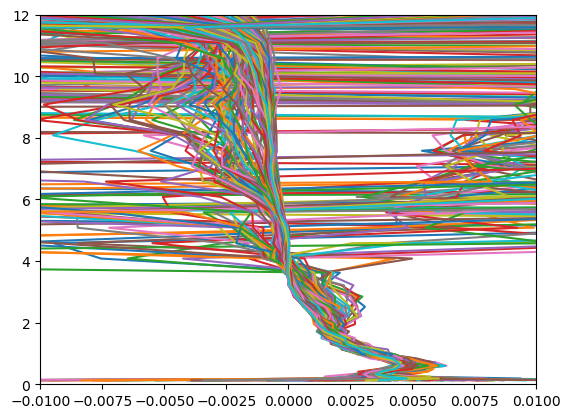

In [38]:
for nt in range(360, 540):
    mean_fmse_plus = np.nanmean(fmse_plus[nt], axis=(-1, -2))
    mean_fmse = np.nanmean(fmse[nt], axis=(-1, -2))
    diff_h = mean_fmse_plus - mean_fmse


    with np.errstate(divide='ignore', invalid='ignore'):
        safe_div = np.where(mean_fmse_plus != 0,
                            np.gradient(mean_fmse_plus, z) / diff_h,
                            0)

    E = -safe_div

    mean_isent = np.mean(rhow_plus_isent[nt], axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        correction = np.where(mean_isent != 0, 1 / mean_isent * np.gradient(mean_isent, z), 0)


    #D = E - 1/np.nanmean(RHO_W_plus[nt], axis=(-1, -2)) * np.gradient(np.nanmean(RHO_W_plus[nt], axis=(-1, -2)), z)
    plt.plot(E, z/1000, label='E')
    plt.xlim(-0.01, 0.01)
    plt.ylim(0,12)
    #plt.plot(E - correction, z/1000, label='dzH-')



In [39]:
E_profiles = []

for nt in range(1, 540):
    mean_fmse_plus = np.nanmean(fmse_plus[nt], axis=(-1, -2))
    mean_fmse = np.nanmean(fmse[nt], axis=(-1, -2))
    diff_h = mean_fmse_plus - mean_fmse

    with np.errstate(divide='ignore', invalid='ignore'):
        safe_div = np.where(mean_fmse_plus != 0,
                            np.gradient(mean_fmse_plus, z) / diff_h,
                            0)
    E = -safe_div
    E_profiles.append(E)

E_profiles = np.array(E_profiles)  # shape: (180, nz)

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/3774725748.py:4: RuntimeWarning: Mean of empty slice
  mean_fmse_plus = np.nanmean(fmse_plus[nt], axis=(-1, -2))


Kept 374 out of 539 profiles.


/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/166227793.py:23: RuntimeWarning: Mean of empty slice
  mean_E_profile = np.nanmean(E_profiles_clean, axis=0)
/opt/anaconda3/envs/samenv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


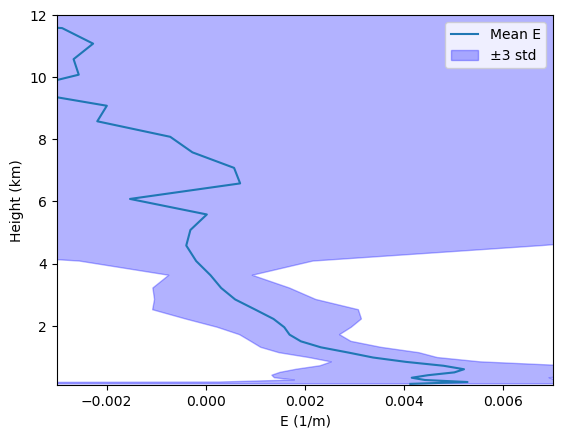

In [40]:
# z: 1D array of height in meters, shape (nz,)
# E_profiles: 2D array, shape (nt, nz)

# Find indices for 100m and 12km
z = simu.dataset_3d.z.values
z_min, z_max = 100, 12000
height_mask = (z >= z_min) & (z <= z_max)  # shape (nz,)

# Apply the value range mask for each profile
lower, upper = -0.5, 0.5
# This checks for each profile if all values in the height range are within [lower, upper]
good_profiles_mask = np.all(
    (E_profiles[:, height_mask] >= lower) & (E_profiles[:, height_mask] <= upper),
    axis=1
)

# Filter the profiles
E_profiles_clean = E_profiles[good_profiles_mask]

print(f"Kept {E_profiles_clean.shape[0]} out of {E_profiles.shape[0]} profiles.")

# Now you can compute mean/std as before
mean_E_profile = np.nanmean(E_profiles_clean, axis=0)
std_E_profile = np.nanstd(E_profiles_clean, axis=0)

# Plot with shaded std
z_km = z / 1000
plt.plot(mean_E_profile, z_km, label='Mean E')
plt.fill_betweenx(z_km, mean_E_profile - 3*std_E_profile, mean_E_profile + 3*std_E_profile, 
                  color='b', alpha=0.3, label='±3 std')
plt.xlim(-0.003, 0.007)
plt.ylim(0.1, 12)
plt.xlabel('E (1/m)')
plt.ylabel('Height (km)')
plt.legend()
plt.show()

In [41]:
E_profiles_clean.shape, E_profiles.shape

((374, 64), (539, 64))

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/4184593155.py:6: RuntimeWarning: Mean of empty slice
  mean_E_profile = np.nanmean(E_profiles, axis=0)  # shape: (nz,)


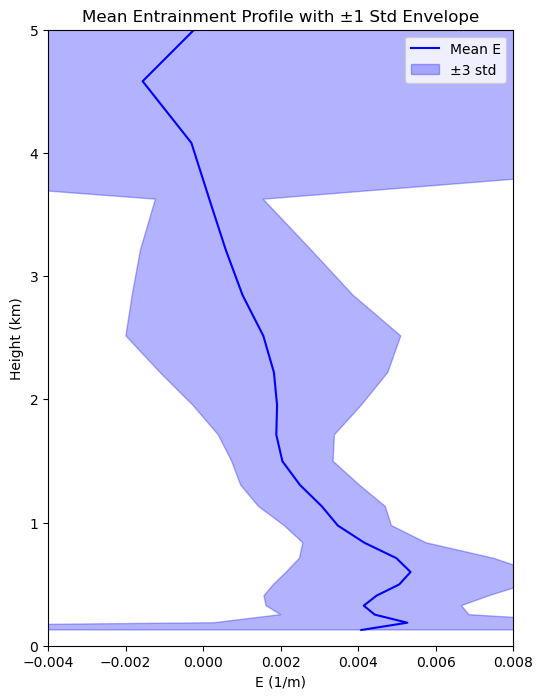

In [42]:
import numpy as np
import matplotlib.pyplot as plt


# Assuming E_profiles is a 2D numpy array of shape (nt, nz)
mean_E_profile = np.nanmean(E_profiles, axis=0)  # shape: (nz,)
std_E_profile = np.nanstd(E_profiles, axis=0)    # shape: (nz,)

z_km = z / 1000  # Convert height to km if needed

plt.figure(figsize=(6, 8))
plt.plot(mean_E_profile, z_km, label='Mean E', color='b')
plt.fill_betweenx(z_km, mean_E_profile - 3*std_E_profile, mean_E_profile + 3*std_E_profile, 
                  color='b', alpha=0.3, label='±3 std')

plt.xlim(-0.004 ,   0.008)
plt.ylim(0, 5)
plt.xlabel('E (1/m)')
plt.ylabel('Height (km)')
plt.legend()
plt.title('Mean Entrainment Profile with ±1 Std Envelope')
plt.show()

In [43]:
import numpy as np

def compute_qice(Q, T, T_freeze=273.15, delta_T=5):
    """
    Compute Qice from total condensate Q using a linear partitioning around freezing.

    Parameters:
    - Q: total condensate mixing ratio (kg/kg)
    - T: temperature (K)
    - T_freeze: freezing temperature, default 273.15 K
    - delta_T: transition width for mixed phase

    Returns:
    - Qice: ice condensate mixing ratio
    """
    Qice = np.zeros_like(Q)
    # Fully ice
    Qice[T < T_freeze - delta_T] = Q[T < T_freeze - delta_T]
    # Fully liquid
    Qice[T > T_freeze + delta_T] = 0
    # Mixed phase
    mask_mixed = (T >= T_freeze - delta_T) & (T <= T_freeze + delta_T)
    frac_ice = (T_freeze + delta_T - T[mask_mixed]) / (2 * delta_T)
    Qice[mask_mixed] = Q[mask_mixed] * frac_ice
    return Qice


In [44]:
simu.dataset_3d.QP

<xarray.DataArray 'QP' (time: 541, z: 64, y: 128, x: 128)> Size: 2GB
array([[[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]],


       ...,


       [[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]]], dtype=float32)
Coordinates:
  * x        (x) float32 512B 0.0 1e+03 2e+03 ... 1.25e+05 1.26e+05 1.27e+05
  * y        (y) float32 512B 0.0 1e+03 2e+03 ... 1.25e+05 1.26e+05 1.27e+05
  * z        (z) float32 256B 25.0 75.0 127.8 ... 2.49e+04 2.589e+04 2.698e+04
  * time     (time) float32 2kB 33.26 33.26 33.26 33.26 ... 34.0 34.0 34.0 34.01
Attributes:
    long_name:     Precipitating Water (Rain+Snow)                           ...
    units:         g/kg      
    cell_methods:  time: mean

In [45]:
Q = simu.dataset_3d.QV + simu.dataset_3d.QN
Q = Q + simu.dataset_3d.QP


In [46]:
def split_qn_to_qice_qliq(QN, T):
    """
    Approximate Qice and Qliq from total condensate QN and temperature T.
    Compatible with xarray.
    """
    T0 = 273.15
    delta_T = 5.0

    # Masks
    ice_mask = T < (T0 - delta_T)
    liq_mask = T > (T0 + delta_T)
    mix_mask = (~ice_mask) & (~liq_mask)

    #print("check", "ice", np.sum(ice_mask*1), np.sum(liq_mask*1), np.sum(mix_mask*1), mix_mask.shape)
    # Fraction of ice in mixed phase
    frac_ice = ((T0 + delta_T - T) / (2 * delta_T)).where(mix_mask, 0.0)

    # Initialize
    Qice = QN.where(ice_mask, 0.0) + QN.where(mix_mask, 0.0) * frac_ice
    Qliq = QN.where(liq_mask, 0.0) + QN.where(mix_mask, 0.0) * (1 - frac_ice)

    return Qice, Qliq



def compute_mse(T, z, QV, QN, cp=1004.0, g=9.81, Lv=2.26e6, Li=3.34e5): #https://fr.wikipedia.org/wiki/Enthalpie_de_changement_d%27%C3%A9tat
    """
    Compute moist static energy using temperature T, height z,
    water vapor mixing ratio QV, and total condensate QN.

    Ice is diagnosed from QN using temperature.
    """
    # Diagnose Qice from QN using temperature
    Qice, _ = split_qn_to_qice_qliq(QN, T)

    # Compute MSE
    MSE = cp * T + g * z + Lv * QV/1000 + Li * Qice/1000
    return MSE


In [47]:
T0 = 273.15
delta_T = 5.0

T = np.mean(simu.dataset_3d.TABS[0,:].values, axis=(-1,-2))
ice_mask = T < (T0 - delta_T)
liq_mask = T > (T0 + delta_T)
mix_mask = (~ice_mask) & (~liq_mask)

print("check", np.sum(ice_mask*1), np.sum(liq_mask*1), np.sum(mix_mask*1), mix_mask.shape)


check 40 21 3 (64,)


In [48]:
h_ice_test = compute_mse(T=simu.dataset_3d.TABS[:100], z=simu.dataset_3d.z, QV=simu.dataset_3d.QV[:100], QN=simu.dataset_3d.QN[:100])

In [49]:
h_ice_test = compute_mse(T=simu.dataset_3d.TABS, z=simu.dataset_3d.z, QV=simu.dataset_3d.QV, QN=simu.dataset_3d.QN)

In [50]:
64*128*128*100, 34374980+5508360+64974260

(104857600, 104857600)

In [51]:
h_ice = compute_mse(T=simu.dataset_3d.TABS, z=simu.dataset_3d.z, QV=simu.dataset_3d.QV, QN=simu.dataset_3d.QN)
h_ice.shape

(541, 64, 128, 128)

In [52]:
Qice, _ = split_qn_to_qice_qliq(QN=simu.dataset_3d.QN, T=simu.dataset_3d.TABS)


In [53]:
mean_qi = np.mean(Qice[10,:], axis=(-1, -2 ))

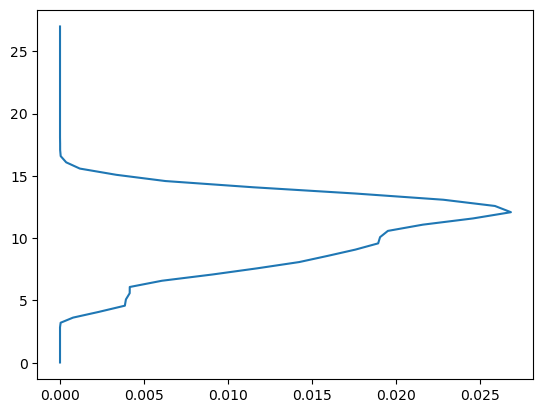

In [54]:
plt.plot(mean_qi, simu.dataset_3d.z/1000)

In [55]:
h_ice.shape

(541, 64, 128, 128)

In [56]:
simu.dataset_computed_3d.FMSE.shape

(541, 64, 128, 128)

In [57]:
nt=100
fmse_nt = simu.dataset_computed_3d.FMSE[nt].values

(320000.0, 350000.0)

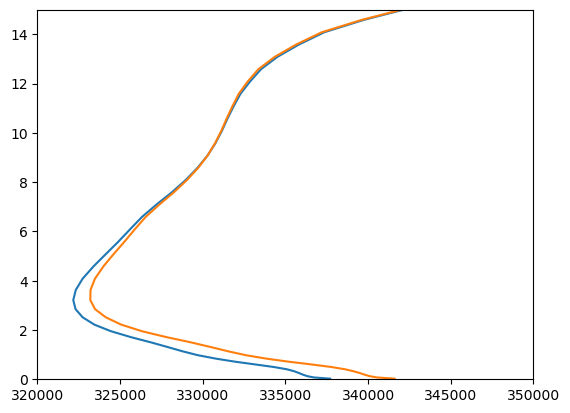

In [58]:
nt=50
z= simu.dataset_3d.z/1000
plt.plot(np.mean(h_ice[nt], axis=(-1, -2)),z)
plt.plot(np.mean(fmse_nt, axis=(-1, -2)), z)
plt.ylim(0,15)
plt.xlim(320000, 350000)


In [59]:
h_ice.shape, rho_w.shape

((541, 64, 128, 128), (541, 64, 128, 128))

In [60]:
h_ice=h_ice.values

In [61]:
#rho_w = simu.dataset_computed_3d.RHO_W.values 
hice_plus = np.full_like(h_ice, np.nan)
hice_minus = np.full_like(h_ice, np.nan)


In [62]:
hice_plus.shape, hice_minus.shape, rho_w.shape

((541, 64, 128, 128), (541, 64, 128, 128), (541, 64, 128, 128))

In [63]:

hice_plus[rho_w > epsilom] = h_ice[rho_w > epsilom]
hice_minus[rho_w < epsilom] = h_ice[rho_w <epsilom]

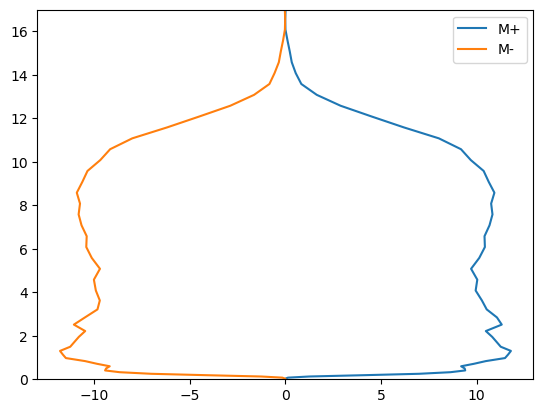

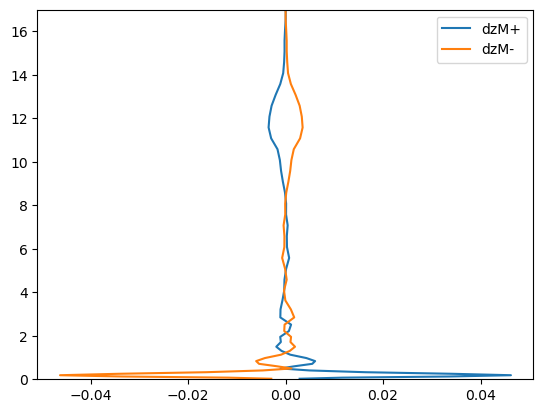

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/2849679809.py:19: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(hice_plus[nt], axis=(-2, -1)), z/1000, label='H+')


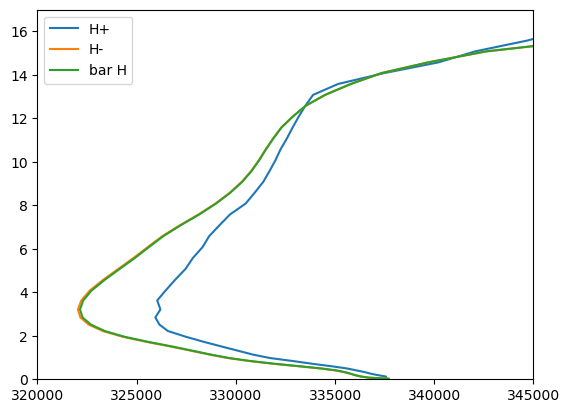

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/2849679809.py:28: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(hice_plus[nt], axis=(-1, -2))-np.nanmean(fmse[nt], axis=(-1, -2)), z/1000, label='H+-bar(Hm)')


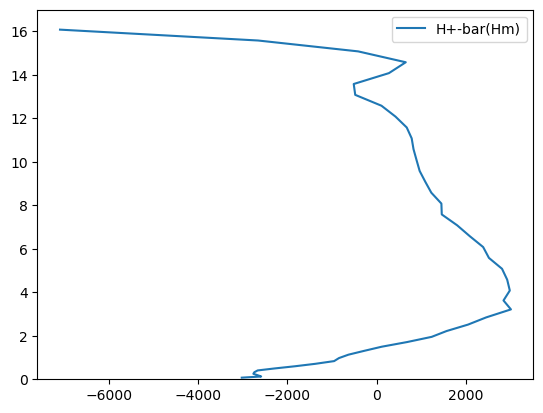

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/2849679809.py:33: RuntimeWarning: Mean of empty slice
  plt.plot(np.gradient(np.nanmean(hice_plus[nt], axis=(-1,-2)), z), z/1000, label='dzH+')


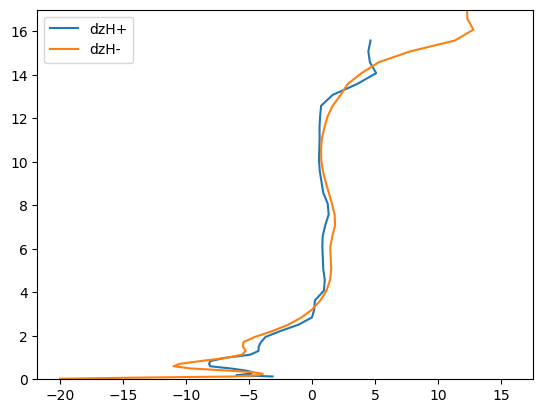

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/2849679809.py:41: RuntimeWarning: Mean of empty slice
  plt.plot(-np.gradient(np.nanmean(hice_plus[nt], axis=(-1,-2)), z), z/1000, label='-dzH+')


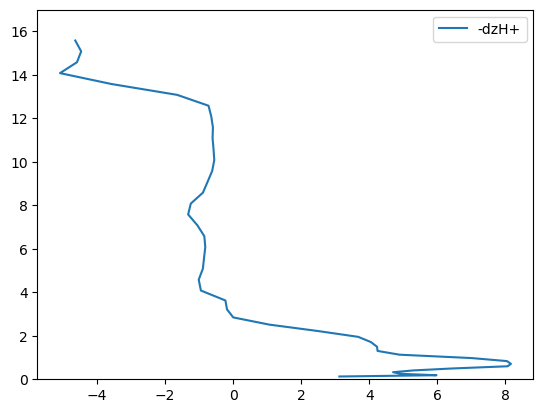

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/2849679809.py:48: RuntimeWarning: Mean of empty slice
  mean_fmse_plus = np.nanmean(hice_plus[nt], axis=(-1, -2))
/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/2849679809.py:54: RuntimeWarning: divide by zero encountered in divide
  inv_M_plus = np.where(M_plus != 0, 1.0 / M_plus, 0)
/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/2849679809.py:71: RuntimeWarning: Mean of empty slice
  D = E - 1/np.nanmean(RHO_W_plus[nt], axis=(-1, -2)) * np.gradient(np.nanmean(RHO_W_plus[nt], axis=(-1, -2)), z)


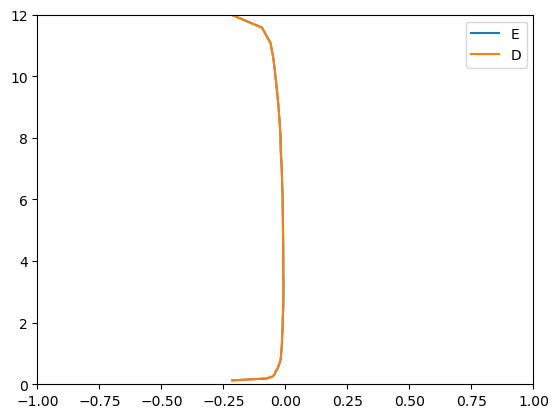

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/2849679809.py:79: RuntimeWarning: Mean of empty slice
  D = E - 1/np.nanmean(RHO_W_plus[nt], axis=(-1, -2)) * np.gradient(np.nanmean(RHO_W_plus[nt], axis=(-1, -2)), z)


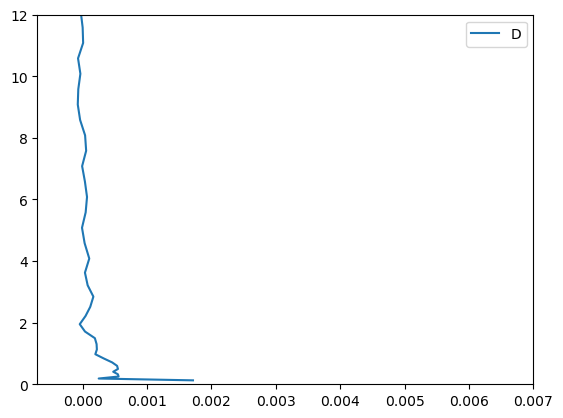

In [64]:
nt=60

z=simu.dataset_3d.z.values

plt.plot(np.nanmean(rhow_plus_isent[nt], axis=1), z/1000, label='M+')
plt.plot(np.nanmean(rhow_minus_isent[nt], axis=1), z/1000, label='M-')
plt.ylim(0,17)
plt.legend()
plt.show()

plt.plot(np.gradient(np.nanmean(rhow_plus_isent[nt], axis=(1)), z), z/1000, label='dzM+')
plt.plot(np.gradient(np.nanmean(rhow_minus_isent[nt], axis=(1)), z), z/1000, label='dzM-')
#plt.plot(grad, z/1000, label='dzM-')

plt.ylim(0,17)
plt.legend()
plt.show()

plt.plot(np.nanmean(hice_plus[nt], axis=(-2, -1)), z/1000, label='H+')
plt.plot(np.nanmean(hice_minus[nt], axis=(-2, -1)), z/1000, label='H-')
plt.plot(np.mean(h_ice[nt], axis=(-2, -1)), z/1000, label='bar H')
plt.xlim(320000, 345000) #for 1000m
plt.ylim(0,17)
plt.legend()
plt.show()


plt.plot(np.nanmean(hice_plus[nt], axis=(-1, -2))-np.nanmean(fmse[nt], axis=(-1, -2)), z/1000, label='H+-bar(Hm)')
plt.ylim(0,17)
plt.legend()
plt.show()

plt.plot(np.gradient(np.nanmean(hice_plus[nt], axis=(-1,-2)), z), z/1000, label='dzH+')
plt.plot(np.gradient(np.nanmean(hice_minus[nt], axis=(-1,-2)), z), z/1000, label='dzH-')
#plt.xlim(-5000, 5000)
plt.ylim(0,17)
plt.legend()
plt.show()


plt.plot(-np.gradient(np.nanmean(hice_plus[nt], axis=(-1,-2)), z), z/1000, label='-dzH+')
#plt.xlim(-5000, 5000)
plt.ylim(0,17)
plt.legend()
plt.show()


mean_fmse_plus = np.nanmean(hice_plus[nt], axis=(-1, -2))
mean_fmse = np.nanmean(h_ice[nt], axis=(-1, -2))
diff_h = mean_fmse_plus - mean_fmse

M_plus = np.nanmean(rhow_plus_isent[nt], axis=1)

inv_M_plus = np.where(M_plus != 0, 1.0 / M_plus, 0)

with np.errstate(divide='ignore', invalid='ignore'):
    safe_div = np.where(mean_fmse_plus != 0,
                        (334*1000*0.001*inv_M_plus-np.gradient(mean_fmse_plus, z)) / diff_h,
                        0)



E = -safe_div


plt.plot(E, z/1000, label='E')
#plt.plot(E - correction, z/1000, label='dzH-')
#plt.xlim(-0.1, 0.5)


D = E - 1/np.nanmean(RHO_W_plus[nt], axis=(-1, -2)) * np.gradient(np.nanmean(RHO_W_plus[nt], axis=(-1, -2)), z)
plt.plot(D, z/1000, label='D')
plt.ylim(0,12)
plt.xlim(-1, 1)
#plt.plot(E - correction, z/1000, label='dzH-')
plt.legend()
plt.show()

D = E - 1/np.nanmean(RHO_W_plus[nt], axis=(-1, -2)) * np.gradient(np.nanmean(RHO_W_plus[nt], axis=(-1, -2)), z)
plt.plot(E-D, z/1000, label='D')
plt.ylim(0,12)
plt.xlim(-0.0007, 0.007)
#plt.plot(E - correction, z/1000, label='dzH-')
plt.legend()
plt.show()


/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/2356448388.py:4: RuntimeWarning: divide by zero encountered in divide
  ax.plot(334*1000*0.0001/(M_plus), z, color='red')


(0.0, 10.0)

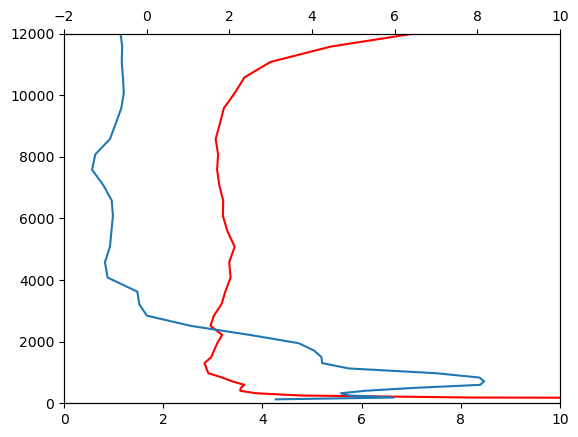

In [65]:
fig, ax = plt.subplots()
ax2=plt.twiny(ax)

ax.plot(334*1000*0.0001/(M_plus), z, color='red')
ax2.plot(-np.gradient(mean_fmse_plus, z),z)

ax.set_ylim(0,12000)
ax2.set_ylim(0,12000)

ax2.set_xlim(-2,10)
ax.set_xlim(0, 10)

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_68709/3558105621.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot((334*1000*0.0001/(M_plus)-np.gradient(mean_fmse_plus, z))/diff_h,z) #rate Pice = 0.0001


(0.0, 12000.0)

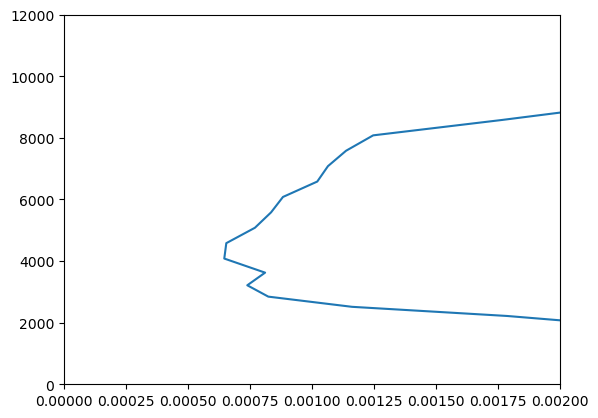

In [66]:
plt.plot((334*1000*0.0001/(M_plus)-np.gradient(mean_fmse_plus, z))/diff_h,z) #rate Pice = 0.0001
plt.xlim(0,20e-4)
plt.ylim(0,12000)


(0.0, 12000.0)

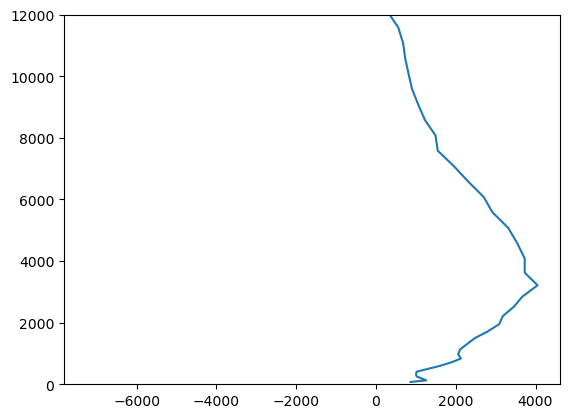

In [67]:
plt.plot(diff_h, z)
plt.ylim(0,12000)

(0.0, 12000.0)

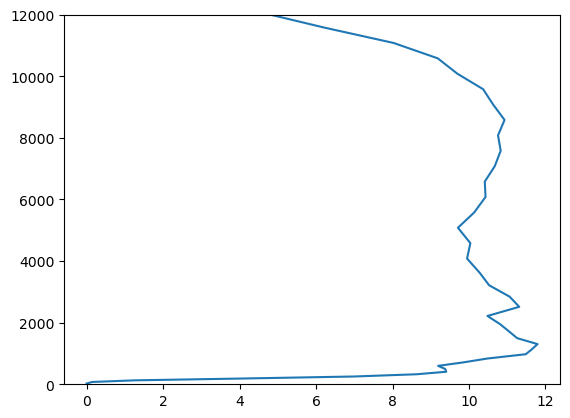

In [68]:
plt.plot(M_plus, z)
plt.ylim(0,12000)

(0.0, 15.0)

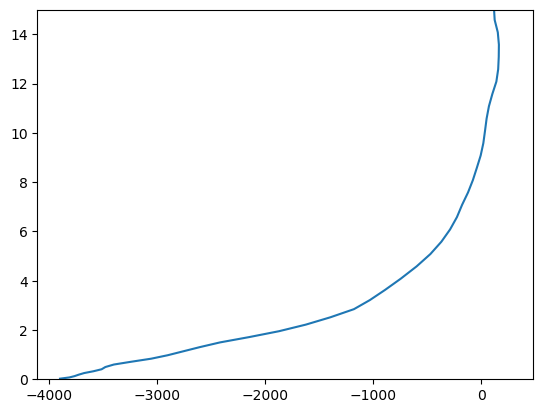

In [69]:
nt=50
z= simu.dataset_3d.z/1000
plt.plot(np.mean(h_ice[nt], axis=(-1, -2))-np.mean(fmse_nt, axis=(-1, -2)),z)
plt.ylim(0,15)
#plt.xlim(320000, 350000)


(array([1.10313993e-06, 5.67431206e-06, 1.53471528e-05, 1.97734185e-05,
        2.64365232e-05, 3.48264983e-05, 3.57715634e-05, 4.21832829e-05,
        5.63851695e-05, 3.46059498e-05, 2.61720749e-05, 2.41244320e-05,
        2.42905806e-05, 3.98593723e-05, 1.92891896e-05, 8.82720792e-06,
        2.87604338e-07, 6.01481581e-06, 3.20642253e-06, 0.00000000e+00,
        4.50261195e-09, 8.62869297e-06, 5.88142839e-07, 0.00000000e+00,
        1.01306900e-07, 8.91348318e-06, 2.06553514e-07, 0.00000000e+00,
        5.35857222e-06, 3.86211540e-06, 5.62826493e-10, 1.85729317e-08,
        8.44521153e-06, 7.57550489e-07, 0.00000000e+00, 6.91094651e-06,
        2.31036015e-06, 0.00000000e+00, 1.42955293e-07, 9.02154586e-06,
        5.68454758e-08, 0.00000000e+00, 2.76342712e-07, 8.93881037e-06,
        6.19109143e-09, 0.00000000e+00, 1.04854576e-06, 8.17208997e-06,
        5.62826493e-10, 0.00000000e+00, 5.62816114e-10, 8.53864073e-06,
        6.82133130e-07, 0.00000000e+00, 0.00000000e+00, 0.000000

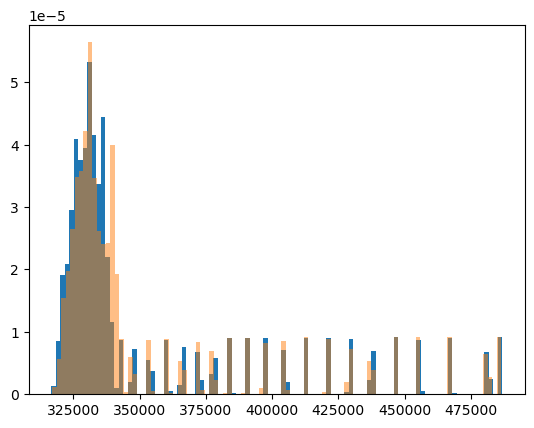

In [71]:
plt.hist(h_ice[10].flatten(), density=True, bins=100)
plt.hist(fmse_nt.flatten(), alpha=0.5, density=True, bins=100)

In [72]:
def partition_qp(QP, T, T0=273.15, delta_T=5.0):
    """
    Partition QP into ice and liquid components based on temperature.
    """
    # Conditions
    ice_mask = T < (T0 - delta_T)
    liq_mask = T > (T0 + delta_T)
    mix_mask = (~ice_mask) & (~liq_mask)

    # Mixed phase fraction
    frac_ice = ((T0 + delta_T - T) / (2 * delta_T)).where(mix_mask, 0.0)

    # Partition
    QP_ice = QP.where(ice_mask, 0.0) + QP.where(mix_mask, 0.0) * frac_ice
    QP_liq = QP.where(liq_mask, 0.0) + QP.where(mix_mask, 0.0) * (1 - frac_ice)

    return QP_ice, QP_liq


In [73]:
QP_ice, QP_liq = partition_qp(QP=simu.dataset_3d.QP, T=simu.dataset_3d.TABS)

In [74]:
mean_ice = np.mean(QP_ice[10], axis=(-1, -2))

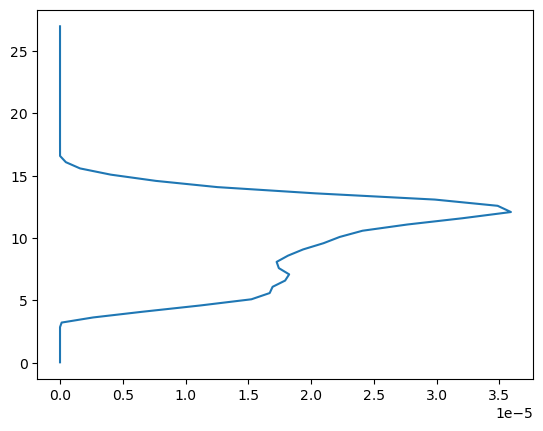

In [75]:
plt.plot(mean_ice/1000, z)

In [76]:
def vertical_profile_ratio(QP, T):
    QP_ice, QP_liq = partition_qp(QP, T)
    
    # Average over horizontal dimensions
    dims_horiz = [dim for dim in QP.dims if dim not in ['z', 'height', 'zcoord']]
    QP_ice_z = QP_ice.mean(dim=dims_horiz)
    QP_liq_z = QP_liq.mean(dim=dims_horiz)
    
    # Avoid divide-by-zero
    ratio = QP_ice_z / QP_liq_z
    ratio = ratio.where(QP_liq_z > 1e-8)
    
    return ratio, QP_ice_z, QP_liq_z


In [77]:
vertical_profile_ratio(QP=simu.dataset_3d.QP, T=simu.dataset_3d.TABS)

(<xarray.DataArray (z: 64)> Size: 256B
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.6969263e-07,
        1.0523398e-02, 2.1865867e-01, 7.7771741e-01, 2.6017439e+00,
        2.8642208e+01, 1.7201866e+03,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
         

In [78]:
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
from pySAMetrics.entrainment_utils import calculate_entrainment_detrainment

In [80]:
outdict = calculate_entrainment_detrainment(simu=simu, time_index=200)

/Users/sophieabramian/Documents/DeepCloudLab/pySAMetrics/src/pySAMetrics/entrainment_utils.py:57: RuntimeWarning: Mean of empty slice
  mean_fmse_plus = np.nanmean(fmse_plus, axis=(-1, -2))  # shape: (nz,)
/Users/sophieabramian/Documents/DeepCloudLab/pySAMetrics/src/pySAMetrics/entrainment_utils.py:59: RuntimeWarning: Mean of empty slice
  mean_rho_w_plus = np.nanmean(rho_w_plus, axis=(-1, -2))  # shape: (nz,)


(-0.002, 0.0023)

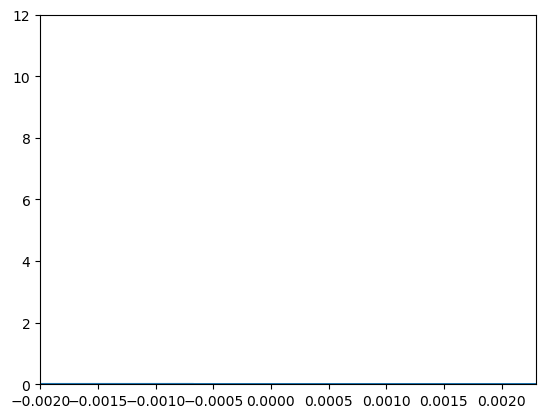

In [81]:
plt.plot(outdict['E'], z/1000)
#plt.plot(outdict['D'], z/1000)
plt.ylim(0,12)
plt.xlim(-0.002, 0.0023)
#plt.plot(outdict['D'], z)

In [82]:
tmean = np.mean(simu.dataset_3d.TABS[100], axis=(-1,-2))

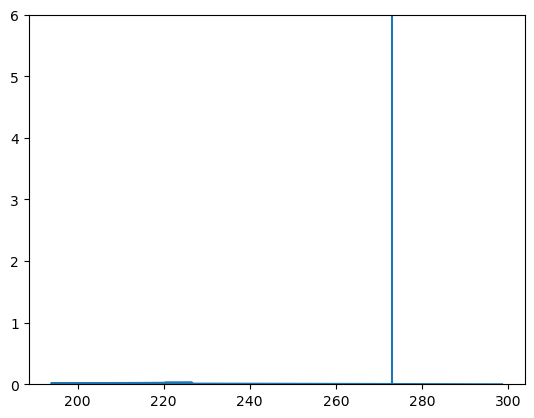

In [83]:
plt.plot(tmean, z/1000)
plt.ylim(0,6)
plt.vlines(273, 0,6)
#plt.xlim(-0.002, 0.0023)
#plt.plot(outdict['D'], z)

(0.0, 12.0)

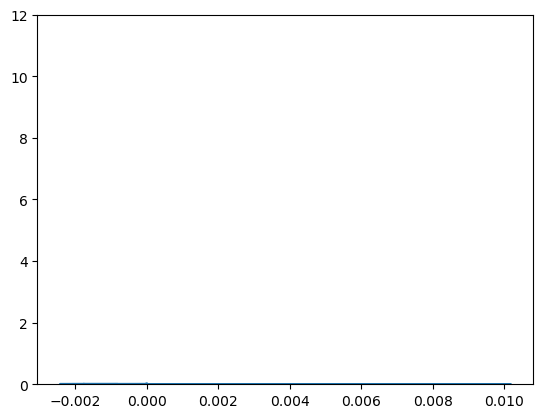

In [84]:
plt.plot(outdict['lf_pice'], z/1000)
plt.ylim(0,12)
#plt.xlim(-0.002, 0.0023)
#plt.plot(outdict['D'], z)

In [85]:
var_pw = np.var(simu.dataset_2d.PW.values)

In [86]:
 PW[time_index]

np.float32(19.06804)

/Users/sophieabramian/Documents/DeepCloudLab/pySAMetrics/src/pySAMetrics/entrainment_utils.py:57: RuntimeWarning: Mean of empty slice
  mean_fmse_plus = np.nanmean(fmse_plus, axis=(-1, -2))  # shape: (nz,)
/Users/sophieabramian/Documents/DeepCloudLab/pySAMetrics/src/pySAMetrics/entrainment_utils.py:59: RuntimeWarning: Mean of empty slice
  mean_rho_w_plus = np.nanmean(rho_w_plus, axis=(-1, -2))  # shape: (nz,)


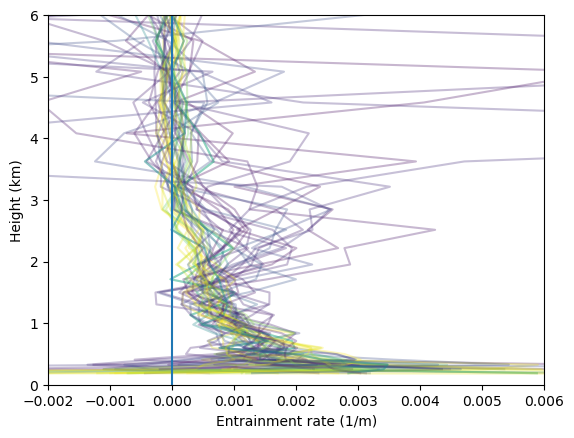

In [87]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

z=simu.dataset_3d.z
PW =  np.var(simu.dataset_2d.PW.values, axis=(-1, -2))
norm = colors.Normalize(vmin=np.min(PW), vmax=np.max(PW))
cmap = cm.viridis

#for time_index in range(20):
for time_index in np.random.randint(0,500,50):
    pw_val = PW[time_index]
    color = cmap(norm(pw_val))  # returns RGBA tuple
    outdict = calculate_entrainment_detrainment(simu=simu, time_index=time_index)
    plt.plot(outdict['D'], z/1000, alpha=0.3, color=color)

plt.vlines(0, 0,6)
plt.ylim(0, 6)
plt.xlim(-0.002, 0.006)
plt.xlabel('Entrainment rate (1/m)')
plt.ylabel('Height (km)')


plt.show()


In [88]:
outdict.keys()

dict_keys(['E', 'D', 'E_minus_D', 'z', 'time_index', 'mean_fmse_plus', 'mean_fmse', 'mean_rho_w_plus', 'lf_pice', 'diff_h'])

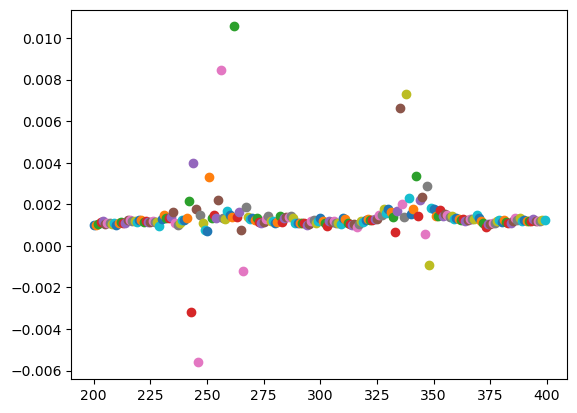

In [89]:
#for time_index in np.random.randint(0,500,50):
for time_index in range(200,400):
    #pw_val = PW[time_index]
    #color = cmap(norm(pw_val))  # returns RGBA tuple
    outdict = calculate_entrainment_detrainment(simu=simu, time_index=time_index)
    plt.scatter(time_index, np.mean(outdict['E'][6:22]))


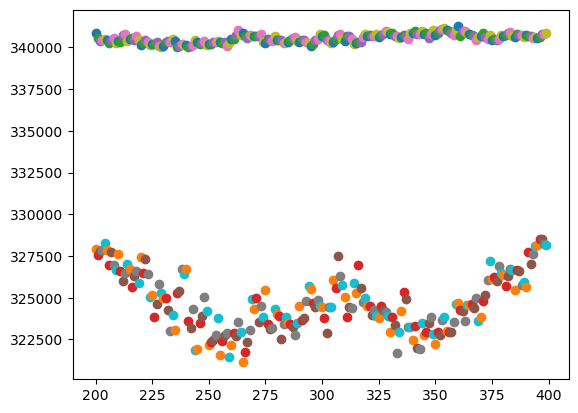

In [90]:
for time_index in range(200, 400):
    #pw_val = PW[time_index]
    #color = cmap(norm(pw_val))  # returns RGBA tuple
    outdict = calculate_entrainment_detrainment(simu=simu, time_index=time_index)
    plt.scatter(time_index, outdict["mean_fmse_plus"][6])
    plt.scatter(time_index, outdict["mean_fmse_plus"][22])

In [91]:
outdict.keys()

dict_keys(['E', 'D', 'E_minus_D', 'z', 'time_index', 'mean_fmse_plus', 'mean_fmse', 'mean_rho_w_plus', 'lf_pice', 'diff_h'])

In [92]:
simu.dataset_3d.TABS.shape

(541, 64, 128, 128)

/Users/sophieabramian/Documents/DeepCloudLab/pySAMetrics/src/pySAMetrics/entrainment_utils.py:57: RuntimeWarning: Mean of empty slice
  mean_fmse_plus = np.nanmean(fmse_plus, axis=(-1, -2))  # shape: (nz,)
/Users/sophieabramian/Documents/DeepCloudLab/pySAMetrics/src/pySAMetrics/entrainment_utils.py:59: RuntimeWarning: Mean of empty slice
  mean_rho_w_plus = np.nanmean(rho_w_plus, axis=(-1, -2))  # shape: (nz,)


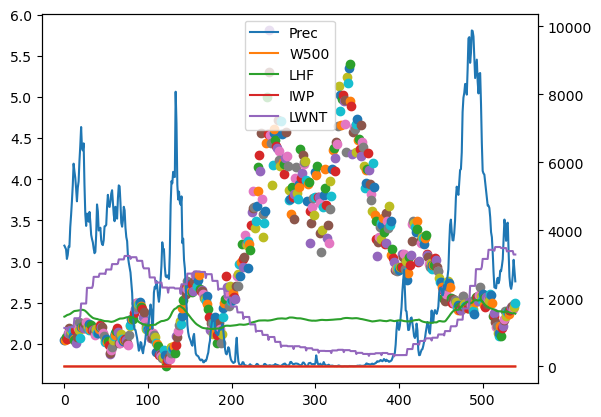

In [104]:
var_pw = np.var(simu.dataset_2d.PW, axis=(-1, -2))



fig, ax = plt.subplots()
ax2 = plt.twinx(ax)
for time_index in range(540):
    #pw_val = PW[time_index]
    #color = cmap(norm(pw_val))  # returns RGBA tuple
    outdict = calculate_entrainment_detrainment(simu=simu, time_index=time_index)
    diff_H = outdict["mean_fmse_plus"]-outdict["mean_fmse"]
    mean_diff_H = np.mean(diff_H[6:22])
    delta_h_plus = outdict["mean_fmse_plus"][6]-outdict["mean_fmse_plus"][22]

    #plt.scatter(delta_h_plus/mean_diff_H, np.mean(outdict['E'][6:22]))
    ax.scatter(time_index, delta_h_plus/mean_diff_H)
for j,data_var in enumerate(all_var_var):
    ax2.plot(data_var[:540], label=variables[j])
plt.legend()


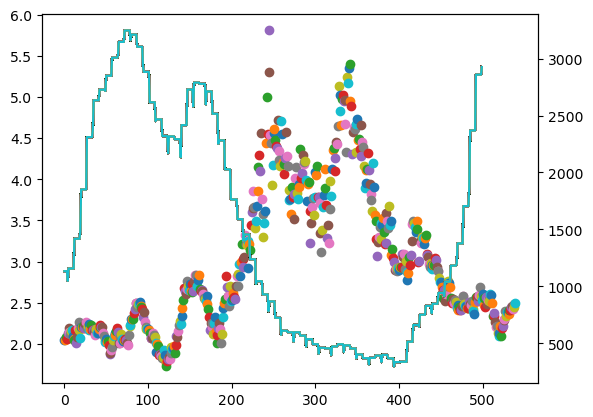

In [103]:




fig, ax = plt.subplots()
ax2 = plt.twinx(ax)
for time_index in range(540):
    #pw_val = PW[time_index]
    #color = cmap(norm(pw_val))  # returns RGBA tuple
    outdict = calculate_entrainment_detrainment(simu=simu, time_index=time_index)
    diff_H = outdict["mean_fmse_plus"]-outdict["mean_fmse"]
    mean_diff_H = np.mean(diff_H[6:22])
    delta_h_plus = outdict["mean_fmse_plus"][6]-outdict["mean_fmse_plus"][22]

    #plt.scatter(delta_h_plus/mean_diff_H, np.mean(outdict['E'][6:22]))
    ax.scatter(time_index, delta_h_plus/mean_diff_H)
    ax2.plot(data_evolution_var[:500])

In [95]:
# --- Load Additional Variables (e.g., Precipitation, W500, etc.) ---

all_var_var = []
all_var_mean = []
variables = ['Prec', 'W500', 'LHF', 'IWP', 'LWNT']
for variable in variables:
    path_var = f'/Volumes/LaCie/000_POSTDOC_2025/long_high_res/var_{variable}.npy'
    path_mean = f'/Volumes/LaCie/000_POSTDOC_2025/long_high_res/mean_{variable}.npy'

    data_evolution_var = np.load(path_var)
    data_evolution_mean = np.load(path_mean)

    all_var_var.append(data_evolution_var)
    all_var_mean.append(data_evolution_mean)

In [ ]:
mean_diff_H

np.float32(4344.9336)

(-0.002, 0.0002)

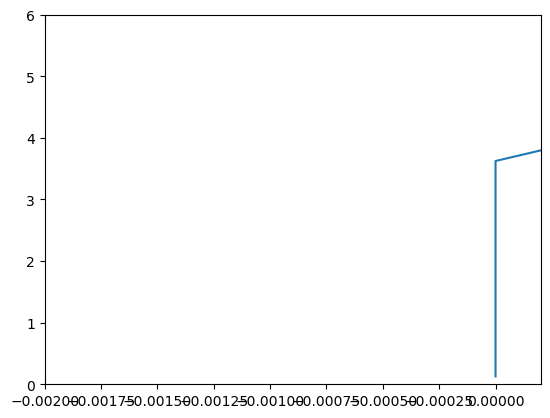

In [ ]:
mplus= outdict['mean_rho_w_plus']
diff_h =  outdict['diff_h']
plt.plot(outdict['lf_pice']/(mplus*diff_h), z/1000)
plt.ylim(0,6)
plt.xlim(-0.002, 0.0002)
#plt.plot(outdict['D'], z)

In [ ]:
np.random.randint(0,100,10)

array([30,  4, 96, 30, 82, 40, 97, 63, 80, 43])

In [ ]:
np.gradient(qn, axis=0)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.